<a href="https://colab.research.google.com/github/Ilvecho/Project_2/blob/main/P2_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import numpy as np
import pandas as pd
import torch

from google.colab import files
files.upload()

raw_data = pd.read_csv('term-deposit-marketing-2020.csv')

Saving term-deposit-marketing-2020.csv to term-deposit-marketing-2020 (1).csv


# Missing values

In [37]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [22]:
print(raw_data.isnull().sum())

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64


We have 40'000 samples, made of 13 features and 1 label.

The features have different data type -> we will need to convert some features in order to have consistent data type across all features.

At first look, it seems that there are no missing values.

In [23]:
raw_data.head(15)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,no


However, by looking at the first samples, we notice that there are some values "unknown" -> there actually are missing values.

Let's see if there are other values equivalent to "missing".

Note that we should check categorical features only

In [38]:
for key in raw_data.keys():

  if raw_data.loc[:, key].dtype == 'O':
    print('---------------------------------')
    print('Value counts for feature: ' + key)
    print(raw_data.loc[:, key].value_counts())
    print('+++++++++++++++++++++++++++++++++')

---------------------------------
Value counts for feature: job
blue-collar      9383
management       8166
technician       6852
admin            4483
services         3910
retired          1437
self-employed    1414
entrepreneur     1405
unemployed       1104
housemaid        1087
student           524
unknown           235
Name: job, dtype: int64
+++++++++++++++++++++++++++++++++
---------------------------------
Value counts for feature: marital
married     24386
single      10889
divorced     4725
Name: marital, dtype: int64
+++++++++++++++++++++++++++++++++
---------------------------------
Value counts for feature: education
secondary    20993
tertiary     11206
primary       6270
unknown       1531
Name: education, dtype: int64
+++++++++++++++++++++++++++++++++
---------------------------------
Value counts for feature: default
no     39191
yes      809
Name: default, dtype: int64
+++++++++++++++++++++++++++++++++
---------------------------------
Value counts for feature: hous

From the print above, we can see that the only missing values are marked as Unknown.
Hence, we need to substitute only all the 'unknown' with NaN

Then, we also need to think about how to deal with missing values:
*   We could leave them missing. 
*   We could fill in with the most frequent value of the feature (risk of unbalancing the dataset)
*   We could remove the rows (risk of information loss)
*   We could build a predictor based on the remaining features. This option is the most complicated to follow up, so let's put it aside for the time being

In [25]:
data = raw_data.copy()
data[raw_data == 'unknown'] = np.nan
print(data.isnull().sum() / data.shape[0] * 100)

age           0.0000
job           0.5875
marital       0.0000
education     3.8275
default       0.0000
balance       0.0000
housing       0.0000
loan          0.0000
contact      31.9125
day           0.0000
month         0.0000
duration      0.0000
campaign      0.0000
y             0.0000
dtype: float64


We can see that three features have missing values:
*   'Job' has 0.58% of values missing -> it's a very small number, we could consider to remove the rows
*   'Education' has 3.82% of values missing
*   'Contact' has 31.91% of missing values -> we cannot remove the rows because we would loose too much information

Since only categorical features have missing values, we could:
*   Leave them missing, i.e. add a category for "NaN"
*   Fill them with the most frequent category

Let's now look at the balance of the features with missing values, to decide how to proceed with the NaN handling (balanced reported in the print above).

The feature job seems fairly balanced, so I would substitute the missing values with the most frequent value.

The feature education is not balanced, but the % of missing values is not high, so once again we could substitute the missing values with the most frequent value.

The feature contact, on the other hand, is very unbalanced (10:1), and the % of missing values is high. Hence, we could:
*   either leave the values NaN as a third class
*   substitute the missing values with the **least** frequent value. 

For now, we are going to follow the second approach.

In [29]:
tmp = data.isnull().sum() / data.shape[0]

for key in tmp.loc[tmp!= 0].keys():

  if tmp.loc[key] < 0.1:
    data.loc[data.loc[:, key].isnull(), key] = data.loc[:, key].value_counts().keys()[0]
  else:
    data.loc[data.loc[:, key].isnull(), key] = data.loc[:, key].value_counts().keys()[-1]


print(data.isnull().sum() / data.shape[0] * 100)

age          0.0
job          0.0
marital      0.0
education    0.0
default      0.0
balance      0.0
housing      0.0
loan         0.0
contact      0.0
day          0.0
month        0.0
duration     0.0
campaign     0.0
y            0.0
dtype: float64


Now we don't have any missing values anymore.

# Outliers

Let's now look for possible outliers.

Note: **categorical** features cannot have outliers, hence we will check only the numeric features.
Furthermore, the feature "day" cannot present outliers as the options are limited

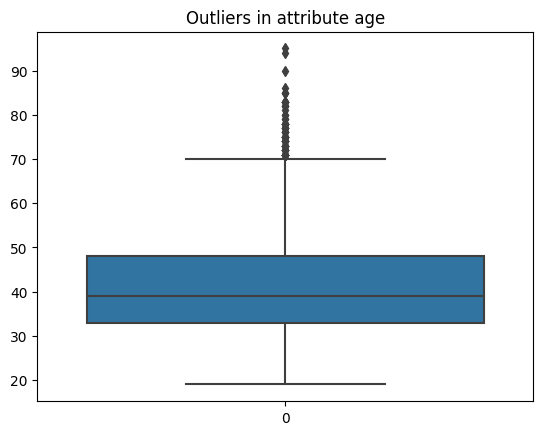

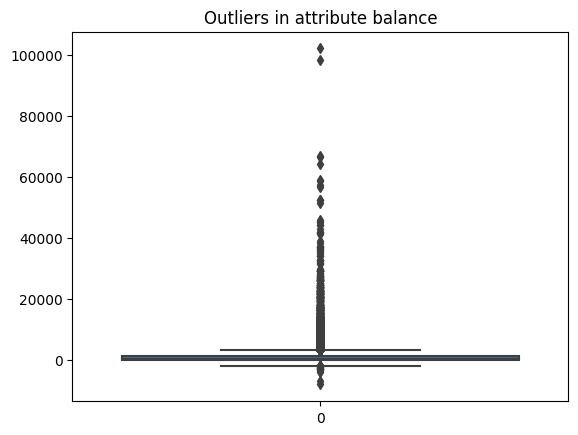

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

numerical_keys = ['age', 'balance']

for key in numerical_keys:
  fig = plt.figure()
  sns.boxplot(data.loc[:, key]).set(title='Outliers in attribute '+key)
  plt.show

Both features present some extreme values, but they are all fairly reasonable. 

Hene, we can conclude that there are no outliers in this dataset.

# Label balance

In [31]:
data['y'].value_counts()

no     37104
yes     2896
Name: y, dtype: int64

The labels of the dataset are **very unbalanced** with a ratio of almost 13:1 between No and Yes.

We will need to keep this in mind while developing the model, especially because the Yes are **more important** than the No

# Encoding

Now we need to encode the categorical features & the label from string to numbers.
We will use sklearn preprocessing Label Encoder function

In [ ]:
from sklearn import preprocessing

encoders_list = {}

for key in data.keys():
  if data.loc[:, key].dtype == 'O':
    le = preprocessing.LabelEncoder()
    data.loc[:, key] = le.fit_transform(data.loc[:, key])
    encoders_list[key] = le.classes_

In [33]:
data.head(15)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,4,1,2,0,2143,1,0,1,5,8,261,1,0
1,44,9,2,1,0,29,1,0,1,5,8,151,1,0
2,33,2,1,1,0,2,1,1,1,5,8,76,1,0
3,47,1,1,1,0,1506,1,0,1,5,8,92,1,0
4,33,1,2,1,0,1,0,0,1,5,8,198,1,0
5,35,4,1,2,0,231,1,0,1,5,8,139,1,0
6,28,4,2,2,0,447,1,1,1,5,8,217,1,0
7,42,2,0,2,1,2,1,0,1,5,8,380,1,0
8,58,5,1,0,0,121,1,0,1,5,8,50,1,0
9,43,9,2,1,0,593,1,0,1,5,8,55,1,0


In [34]:
attributes = data.drop('y', axis=1)
labels = data['y']

# Correlation

Now that all the features are numerical, we can compute the correlation between features, and the correlation between the features and the label

In [35]:
print(attributes.corrwith(labels))

age         -0.020273
job          0.017422
marital      0.030229
education    0.047336
default     -0.006559
balance      0.030232
housing     -0.054336
loan        -0.031029
contact     -0.085433
day         -0.006420
month       -0.046141
duration     0.461169
campaign    -0.040350
dtype: float64


We notice that the duration of the call is much more correlated to the label than all the other features.

Furthermore, we notice that feature 'default' and 'day' have less correlation to the label than the other features.



In [36]:
print(attributes.corr())

                age       job   marital  education   default   balance  \
age        1.000000 -0.030204 -0.386716  -0.147335 -0.014857  0.081517   
job       -0.030204  1.000000  0.051609   0.200575 -0.003525  0.012832   
marital   -0.386716  0.051609  1.000000   0.106973 -0.004595  0.008542   
education -0.147335  0.200575  0.106973   1.000000 -0.008158  0.069176   
default   -0.014857 -0.003525 -0.004595  -0.008158  1.000000 -0.070069   
balance    0.081517  0.012832  0.008542   0.069176 -0.070069  1.000000   
housing   -0.179606 -0.097060  0.004453  -0.074243 -0.019229 -0.049946   
loan       0.000041 -0.017015 -0.042975  -0.021786  0.075006 -0.080596   
contact    0.068206 -0.084967 -0.030818  -0.148430  0.002889 -0.004086   
day       -0.011689  0.030951  0.000099   0.039727  0.006287  0.011662   
month     -0.063437 -0.102927 -0.006779  -0.086235  0.013660  0.023718   
duration  -0.036270 -0.000600  0.015772   0.003885 -0.008597  0.014072   
campaign   0.016204  0.010054 -0.00125

There are some features that have very low correlation with other features, but this is not relevat:

It simply means that the features are bringing different information.

On the other hand, there are no couple of features highly correlated: 

This means that all the features should be important, as no feature is a duplicate of another

# Model

This is a classification problem, so we can use **XGBoost** as a model.

This time the database is big enough, so we could also explore some **Neural Network** architectures (e.g. MLPs), and see how they perform compared to XGB. 